In [1]:

# LSTM model dummy
# Dummy model to predict the climate time series data

# !nvidia-smi

import tensorflow as tf 
# !pip install tensorflow-gpu
print(tf.__version__)

print('1: ', tf.config.list_physical_devices('GPU'))
print('2: ', tf.test.is_built_with_cuda)
print('3: ', tf.test.gpu_device_name())
print('4: ', tf.config.get_visible_devices())

2.6.2
1:  []
2:  <function is_built_with_cuda at 0x7ff8fa4eeea0>
3:  
4:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, RepeatVector, TimeDistributed
import math
from sklearn.metrics import mean_squared_error , roc_curve, auc

## Data Processing

### Data Fetching and Cleaning

In [3]:


# create a dataset of 30 sequences from the provided Data
def creatDataset(x,y,time_step):
    Xs, Ys = [],[]
    for i in range(len(x)-time_step):
        v = x.iloc[i:i+time_step].values
        Xs.append(v)
        Ys.append(x.iloc[i+time_step])
    return np.array(Xs),np.array(Ys)
    

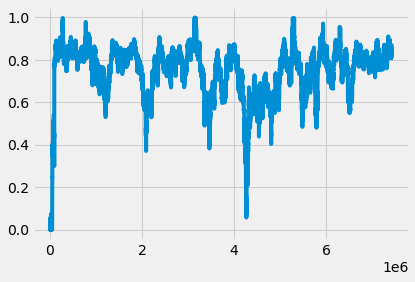

In [4]:
#getting data

scaler = MinMaxScaler()
df_normal = pd.read_csv('train_1.csv', delimiter=',')
df_normal_grp_ID1 = df_normal[df_normal['ID']=='id1'].dropna(axis=1, how='all')
df_normal_grp_ID1 = df_normal_grp_ID1.drop(df_normal_grp_ID1[['Label','ID']],axis =1)
# df_normal_grp_ID1 = df_normal_grp_ID1.iloc[0:(int(len(df_normal_grp_ID1)/5)),:]
# df_normal_grp_ID1 = df_normal_grp_ID1.iloc[200000:300000,:]
df_normal_grp_ID1[['Time']] = scaler.fit_transform(df_normal_grp_ID1[['Time']])
# df_normal_grp_ID1
plt.plot(df_normal_grp_ID1['Signal1'])

In [6]:
df_normal_grp_ID1['Signal1']

5          0.000000
12         0.000000
20         0.000000
27         0.000000
33         0.000000
             ...   
7417396    0.876350
7417403    0.876500
7417410    0.876641
7417417    0.876771
7417425    0.876901
Name: Signal1, Length: 1034952, dtype: float64

         Label      Time  Signal1_of_ID  Signal2_of_ID
1            0  0.000000       0.165060           0.25
7            0  0.000003       0.165400           0.50
16           0  0.000007       0.165821           0.75
22           0  0.000010       0.166301           1.00
29           0  0.000013       0.166662           0.00
...        ...       ...            ...            ...
2150020      0  0.999987       0.617179           0.75
2150028      0  0.999990       0.617330           1.00
2150035      0  0.999993       0.617460           0.00
2150043      0  0.999997       0.617570           0.25
2150048      0  1.000000       0.617650           0.50

[299997 rows x 4 columns]


Text(0.5, 1.0, 'Plateau Attack (180000-190000) values')

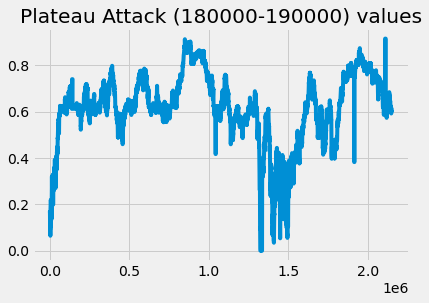

In [5]:
df_test_plat_ID1 = pd.read_csv('test_plateau.csv', delimiter=',')
df_test_plat_ID1 = df_test_plat_ID1[df_test_plat_ID1['ID']=='id1'].dropna(axis=1, how='all')
df_test_plat_ID1 = df_test_plat_ID1.drop(df_test_plat_ID1[['ID']],axis =1)
# df_test_plat_ID1 = df_test_plat_ID1.iloc[0:(int(len(df_test_plat_ID1)/5)),:]
# df_test_plat_ID1 = df_test_plat_ID1.iloc[180000:200000,:]
df_test_plat_ID1[['Time']] = scaler.fit_transform(df_test_plat_ID1[['Time']])

# df_test_plat_ID1.iloc[180000:250000,0:2]

# plt.plot(df_test_plat_ID1.iloc[180000:190000,1:2])
print(df_test_plat_ID1)
plt.plot(df_test_plat_ID1.iloc[:,2:3])
plt.title('Plateau Attack (180000-190000) values')

In [6]:
TIME_STEP = 30
X_train, Y_train = creatDataset(df_normal_grp_ID1[['Signal1']], df_normal_grp_ID1[['Signal1']], TIME_STEP)
X_test, Y_test = creatDataset(df_test_plat_ID1[['Signal1_of_ID']], df_test_plat_ID1[['Signal1_of_ID']], TIME_STEP)


In [9]:
Y_train.shape

# X_test.shape

(1034922, 1)

### LSTM AUTOENCODER
#### Model Desgin

In [16]:


# n_features = X_train.shape[2]
model= Sequential()
model.add(LSTM(128, activation = 'relu', 
input_shape =(X_train.shape[1],X_train.shape[2]), return_sequences = True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(TIME_STEP))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 247,937
Trainable params: 247,937
Non-trainable params: 0
__________________________________________________

#### Model Fitting

In [19]:
# fit model
model.fit(X_train, Y_train, epochs=5, batch_size=30, validation_split=0.1, shuffle=False)
model.save("single_ID_LSTM_autoenc_old")

Epoch 1/5
31048/31048 [==============================] - 803s 26ms/step - loss: 0.0138 - val_loss: 0.0319
Epoch 2/5
31048/31048 [==============================] - 803s 26ms/step - loss: 0.0163 - val_loss: 0.0291
Epoch 3/5
31048/31048 [==============================] - 786s 25ms/step - loss: 0.0186 - val_loss: 0.0292
Epoch 4/5
31048/31048 [==============================] - 777s 25ms/step - loss: 0.0210 - val_loss: 0.0290
Epoch 5/5
31048/31048 [==============================] - 774s 25ms/step - loss: 0.0195 - val_loss: 0.0291
INFO:tensorflow:Assets written to: single_ID_LSTM_autoenc_old/assets


#### Training loss, finding Threshold

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


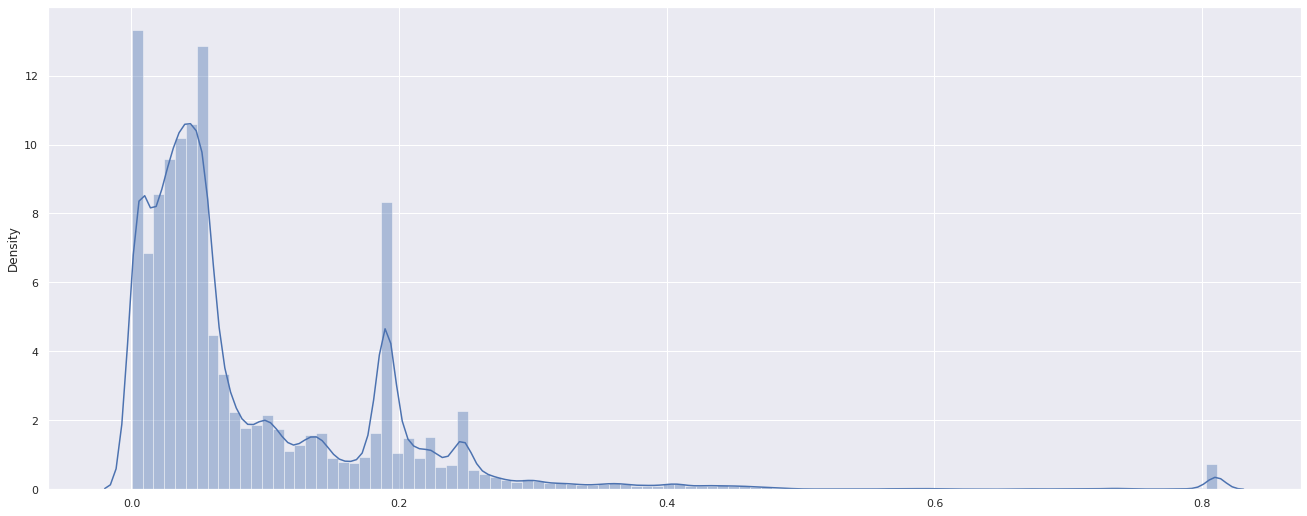

In [7]:
reconstructed_model = keras.models.load_model("single_ID_LSTM_autoenc_old")
x_train_predict = reconstructed_model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(x_train_predict - X_train), axis=1)
sns.set(rc={'figure.figsize':(20,8.27)})
sns.distplot(train_mae_loss,bins=100,kde=True)
plt.savefig('training_loss.png')


### Test Loss

(299967, 1)


/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

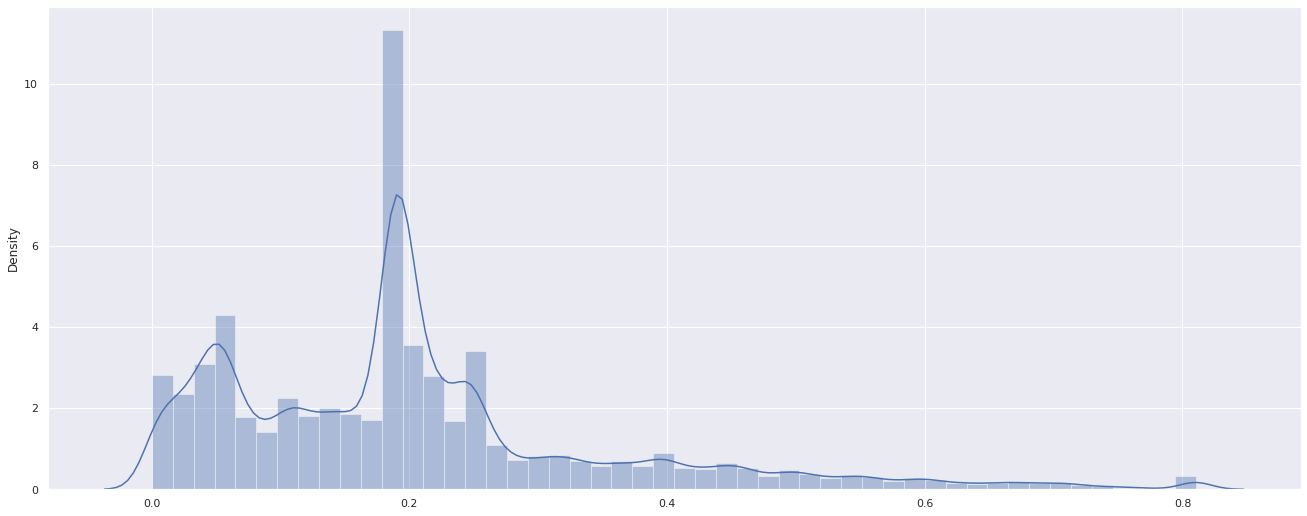

In [8]:

x_test_predict = reconstructed_model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(x_test_predict - X_test), axis=1)
print(test_mae_loss.shape)

sns.distplot(test_mae_loss,bins=50,kde=True )

### Test Score Dataframe Creation and plotting


In [13]:
print(df_test_plat_ID1[TIME_STEP:].index.shape)
print(test_mae_loss.shape)

(299967,)
(299967, 1)


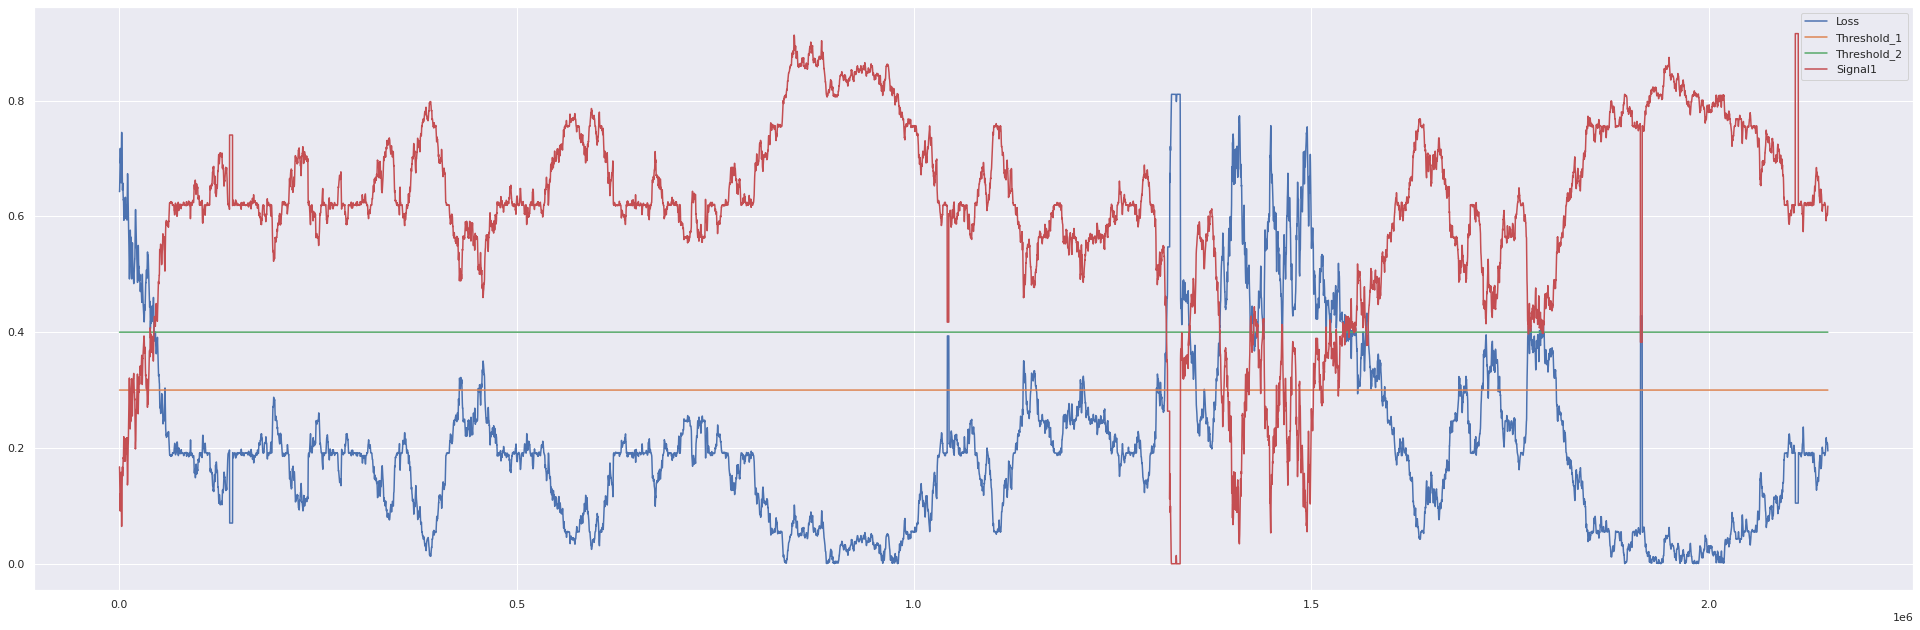

In [32]:
test_score_df = pd.DataFrame(index=df_test_plat_ID1[TIME_STEP:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold_1'] = 0.3
test_score_df['threshold_2'] = 0.4
test_score_df['anomaly_1'] = test_score_df.loss > test_score_df.threshold_1
test_score_df['anomaly_2'] = test_score_df.loss > test_score_df.threshold_2
test_score_df['Signal1'] = df_test_plat_ID1[TIME_STEP:].Signal1_of_ID
test_score_df['Label'] = df_test_plat_ID1[TIME_STEP:].Label
#plot the threshoold vs the actual loss values
plt.figure(figsize=(30,10))
plt.plot(test_score_df.index, test_score_df.loss, label='Loss')
plt.plot(test_score_df.index, test_score_df.threshold_1, label='Threshold_1')
plt.plot(test_score_df.index, test_score_df.threshold_2, label='Threshold_2')
plt.plot(test_score_df.index,test_score_df.Signal1, label='Signal1')
plt.legend()


#### ROC Curves

In [33]:
def tpr_fpr_cal(anom,notAnom):

    TPs = anom[anom.Label == anom.anomaly_x]
    FPs = anom[anom.Label != anom.anomaly_x]
    FNs= notAnom[notAnom.Label != notAnom.anomaly_x]
    TNs= notAnom[notAnom.Label == notAnom.anomaly_x]

    tpr = TPs.iloc[:,0].shape[0] / (TPs.iloc[:,0].shape[0] + FNs.iloc[:,0].shape[0])
    fpr = FPs.iloc[:,0].shape[0]/ (FPs.iloc[:,0].shape[0] + TNs.iloc[:,0].shape[0])
    # print(tpr)
    # print(fpr)

    return tpr,fpr

In [34]:
def roc_from_scratch(test_df, partitions=100):
    roc = np.array([])
    for i in range(partitions + 1):
        test_df['anomaly_x'] = test_df.loss > (i / partitions)
        anomalies = test_df[test_df.loss > (i / partitions)]
        notAnomalies =  test_df[test_df.loss <= (i / partitions)]
        
        # print(notAnomalies)
        tpr, fpr = tpr_fpr_cal(anomalies, notAnomalies)
        if(0.15 > tpr < 0.23):
            print(i / partitions)

        roc = np.append(roc, [fpr, tpr])
        # print(roc)
        
    return roc.reshape(-1, 2)

0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99
1.0


Text(0, 0.5, 'True Positive Rate')

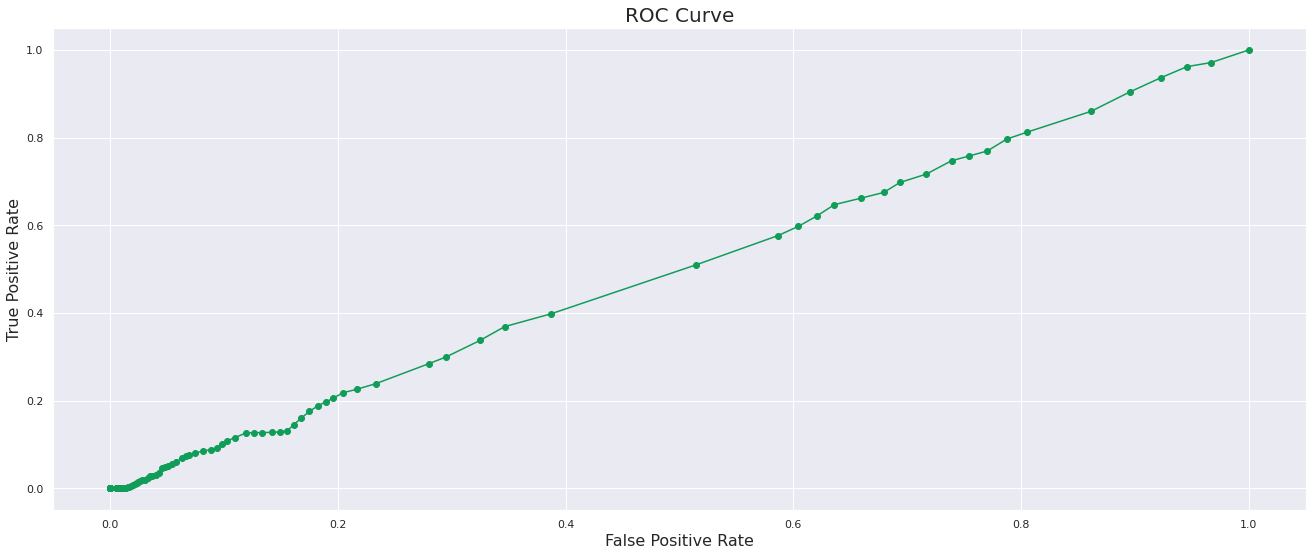

In [35]:
roc = roc_from_scratch(test_score_df)
plt.plot(roc[:,0],roc[:,1],color='#0F9D58', marker='o')
plt.title('ROC Curve',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)

#### Confusion Matrix Creation

In [36]:
def conf_matrix_cal_1(anom,notAnom,mode):

    TPs = anom[anom.Label == anom.anomaly_1]
    FPs = anom[anom.Label != anom.anomaly_1]
    FNs= notAnom[notAnom.Label != notAnom.anomaly_1]
    TNs= notAnom[notAnom.Label == notAnom.anomaly_1]

    if(mode == 'num'):
        return TPs.iloc[:,0].shape[0],FPs.iloc[:,0].shape[0],FNs.iloc[:,0].shape[0],TNs.iloc[:,0].shape[0]
    else:
        return TPs,FPs,FNs,TNs

In [37]:
def conf_matrix_cal_2(anom,notAnom,mode):

    TPs = anom[anom.Label == anom.anomaly_2]
    FPs = anom[anom.Label != anom.anomaly_2]
    FNs= notAnom[notAnom.Label != notAnom.anomaly_2]
    TNs= notAnom[notAnom.Label == notAnom.anomaly_2]

    if(mode == 'num'):
        return TPs.iloc[:,0].shape[0],FPs.iloc[:,0].shape[0],FNs.iloc[:,0].shape[0],TNs.iloc[:,0].shape[0]
    else:
        return TPs,FPs,FNs,TNs

In [38]:
anomalies_1 = test_score_df[test_score_df.anomaly_1 == True]
anomalies_2 = test_score_df[test_score_df.anomaly_2 == True]


notAnomalies_1 = test_score_df[test_score_df.anomaly_1 == False]
notAnomalies_2 = test_score_df[test_score_df.anomaly_2 == False]


stats = np.empty([2,4],dtype='int')

stats[0] = conf_matrix_cal_1(anomalies_1,notAnomalies_1,'num')
stats[1] = conf_matrix_cal_2(anomalies_2,notAnomalies_2,'num')

stats_df_1 = conf_matrix_cal_1(anomalies_1,notAnomalies_1,'df')
stats_df_2 = conf_matrix_cal_2(anomalies_2,notAnomalies_2,'df')


print(stats)
print(stats_df_1)

[[  9238  45841  39723 205165]
 [  5646  27481  43315 223525]]
(             loss  threshold_1  threshold_2  anomaly_1  anomaly_2   Signal1  \
14592    0.547484          0.3          0.4       True       True  0.282805   
14598    0.546266          0.3          0.4       True       True  0.283685   
14605    0.545042          0.3          0.4       True       True  0.284596   
14613    0.543814          0.3          0.4       True       True  0.285487   
14620    0.542586          0.3          0.4       True       True  0.286268   
...           ...          ...          ...        ...        ...       ...   
1916291  0.428105          0.3          0.4       True       True  0.382656   
1916299  0.428105          0.3          0.4       True       True  0.382656   
1916306  0.428105          0.3          0.4       True       True  0.382656   
1916314  0.428105          0.3          0.4       True       True  0.382656   
1916319  0.428105          0.3          0.4       True       True  

#### Total anomalies Plotted: Predicted VS Test 

[[  9238  45841  39723 205165]
 [  5646  27481  43315 223525]]


([<matplotlib.patches.Wedge at 0x7ff897d6beb8>,
 [Text(1.1979027064198384, 0.07091618963273978, 'TPs'),
  Text(1.0105463094923794, 0.43450679669175757, 'FPs'),
  Text(0.49288875559747636, 1.094102680101631, 'FNs'),
  Text(-0.765914256207711, -0.7895412289030821, 'TNs')])

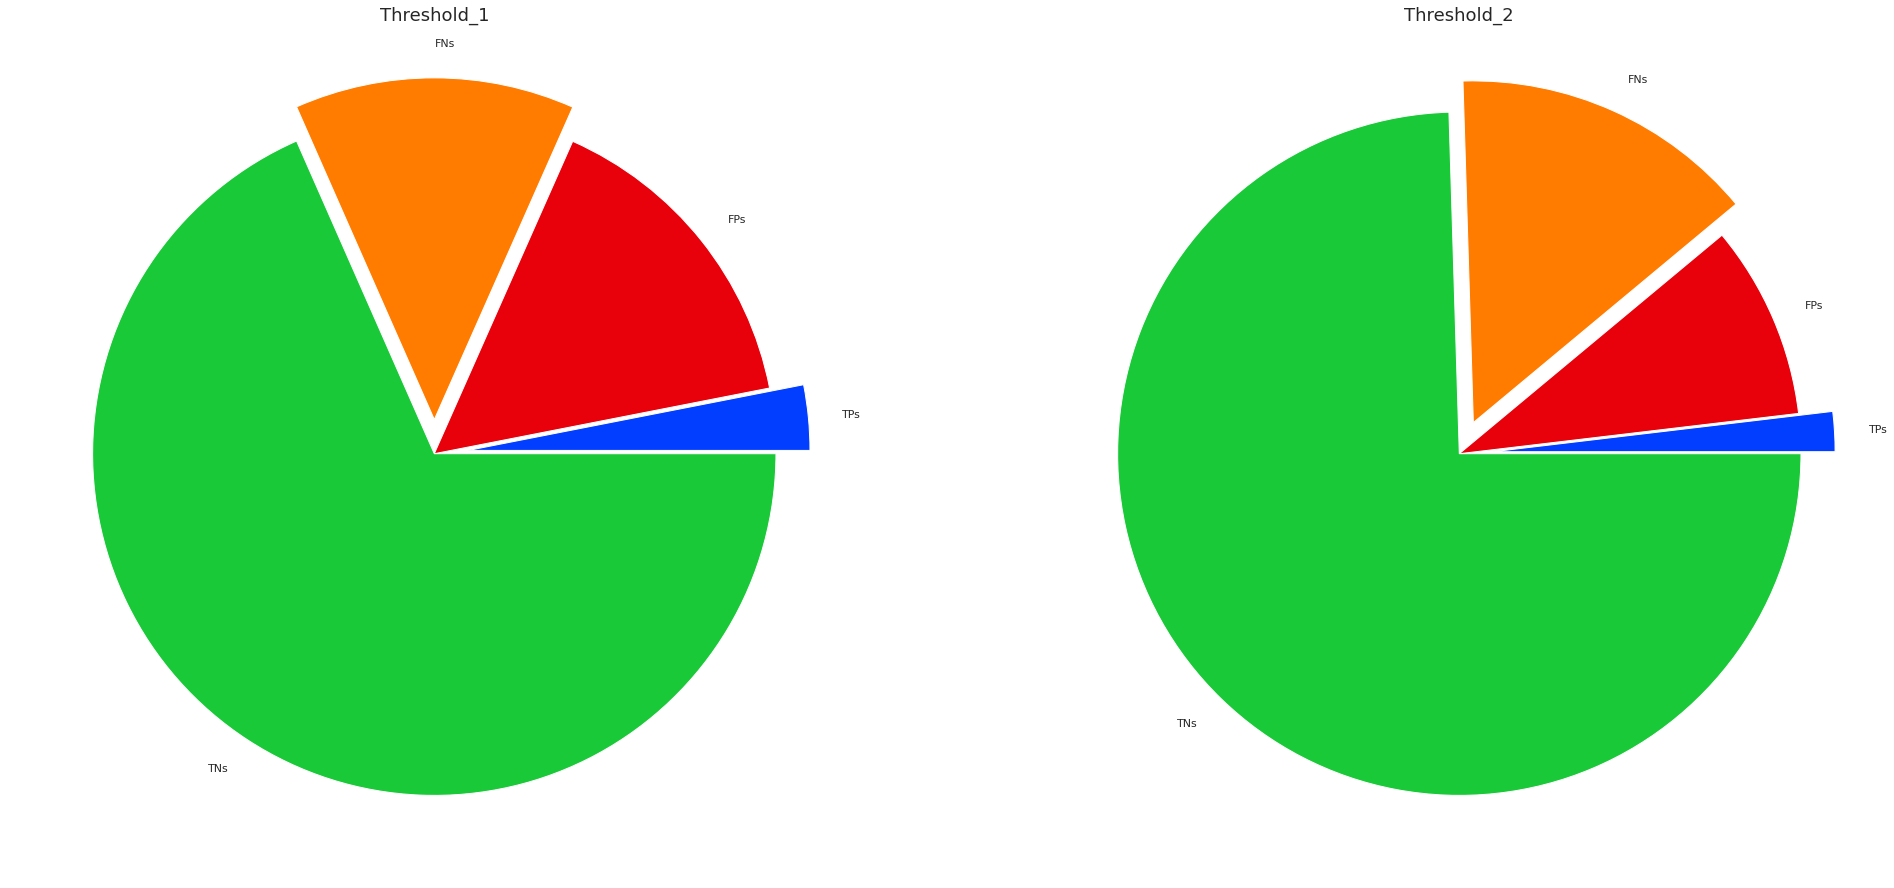

In [39]:
print(stats)
pallete = sns.color_palette('bright')
colors = [pallete[0],pallete[3],pallete[1],pallete[2]]
fig,axs = plt.subplots(1,2,squeeze=False, figsize=(30,20))
fig.set_facecolor('white')
labels = ['TPs', 'FPs', 'FNs', 'TNs']
explode = (0.1, 0, 0.1, 0)

# axs[0].set_title('Threshold 1',fontsize=18)

axs[0,0].set_title('Threshold_1',fontsize=18)
axs[0,0].pie(
stats[0],
labels = labels,
colors = colors,
explode = explode,
 )

axs[0,1].set_title('Threshold_2',fontsize=18)
axs[0,1].pie(
stats[1],
labels = labels,
colors = colors,
explode = explode,
 )


/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

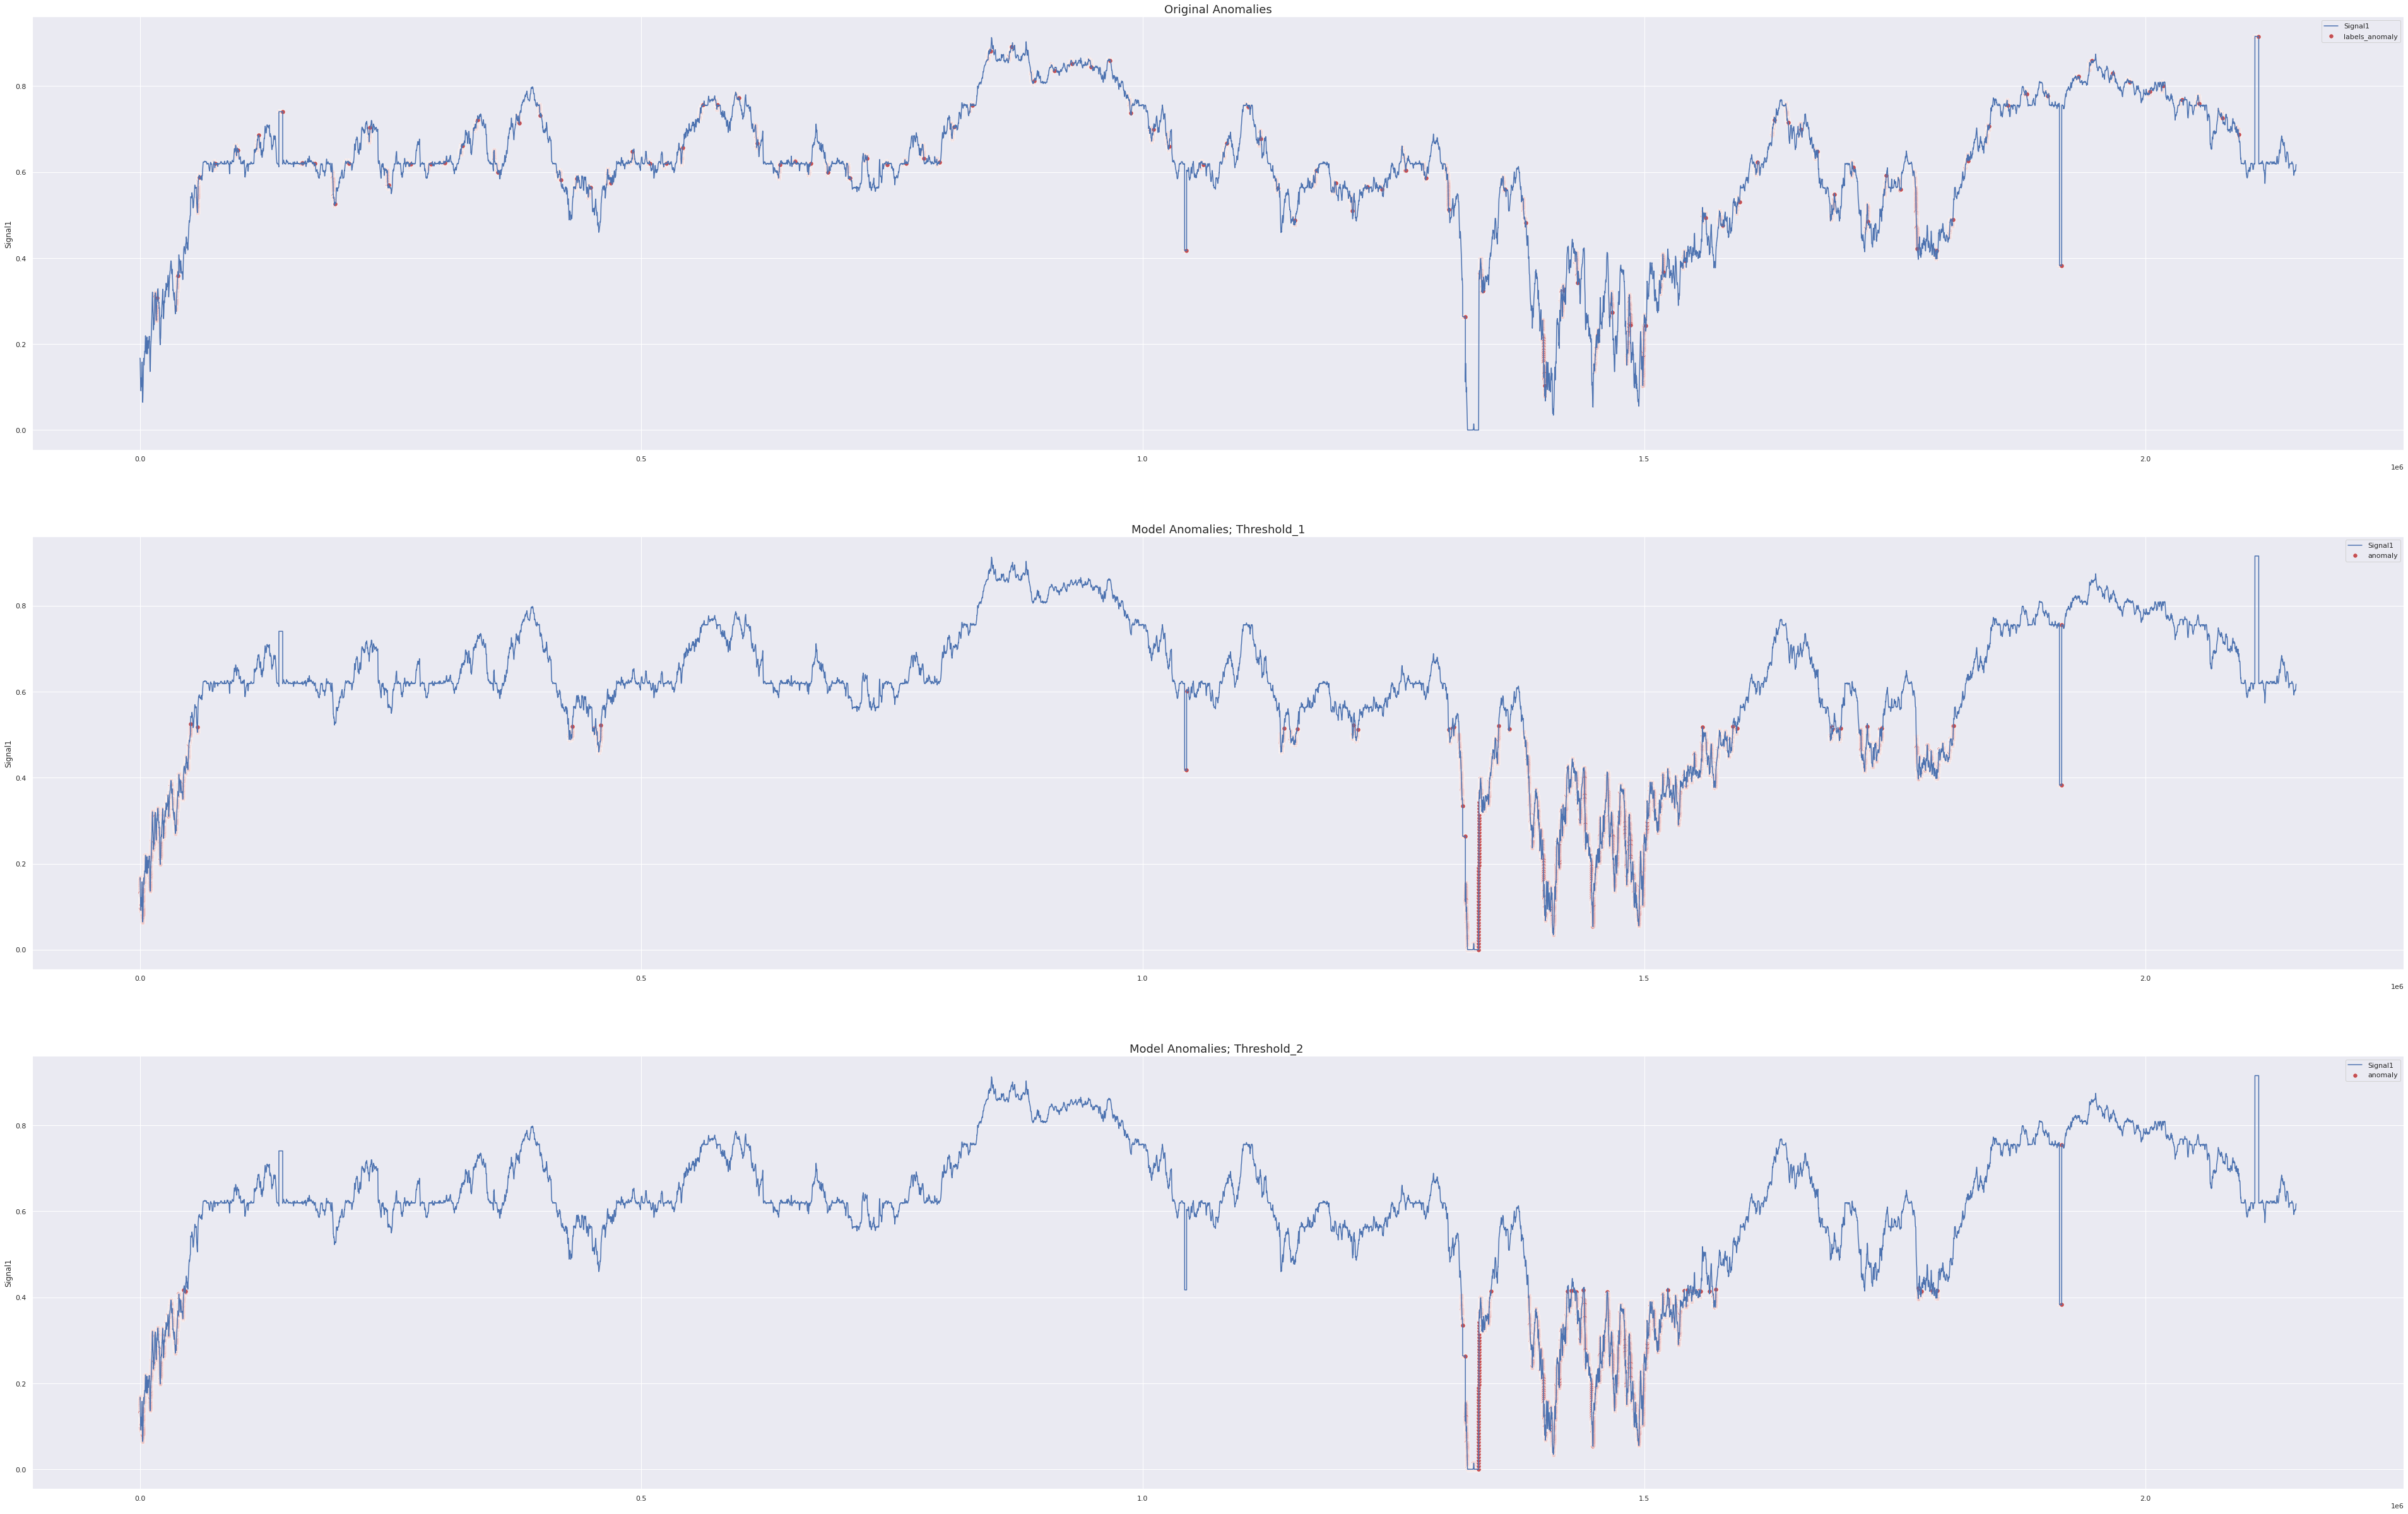

In [40]:
fig,axs = plt.subplots(3,1,squeeze=False, figsize=(60,40))

axs[0,0].set_title('Original Anomalies',fontsize=18)
axs[0,0].plot(
 test_score_df.index, 
 test_score_df.Signal1, 
  label='Signal1'
)

test_labels = test_score_df[test_score_df.Label == True]

sns.scatterplot(
  test_labels.index,
  test_labels.Signal1,
  color=sns.color_palette()[3],
  s=52,
  label='labels_anomaly',
  ax = axs[0,0]
)

axs[1,0].set_title('Model Anomalies; Threshold_1',fontsize=18)

axs[1,0].plot(
  test_score_df.index, 
  test_score_df.Signal1, 
  label='Signal1'
  )

sns.scatterplot(
  anomalies_1.index,
  anomalies_1.Signal1,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly',
  ax = axs[1,0]
)
axs[2,0].set_title('Model Anomalies; Threshold_2 ',fontsize=18)

axs[2,0].plot(
  test_score_df.index, 
  test_score_df.Signal1, 
  label='Signal1'
  )

sns.scatterplot(
  anomalies_2.index,
  anomalies_2.Signal1,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly',
  ax = axs[2,0]
)

plt.legend();

#### TPs and FPs VS TNs and FNs

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywor

<AxesSubplot:ylabel='Signal1'>

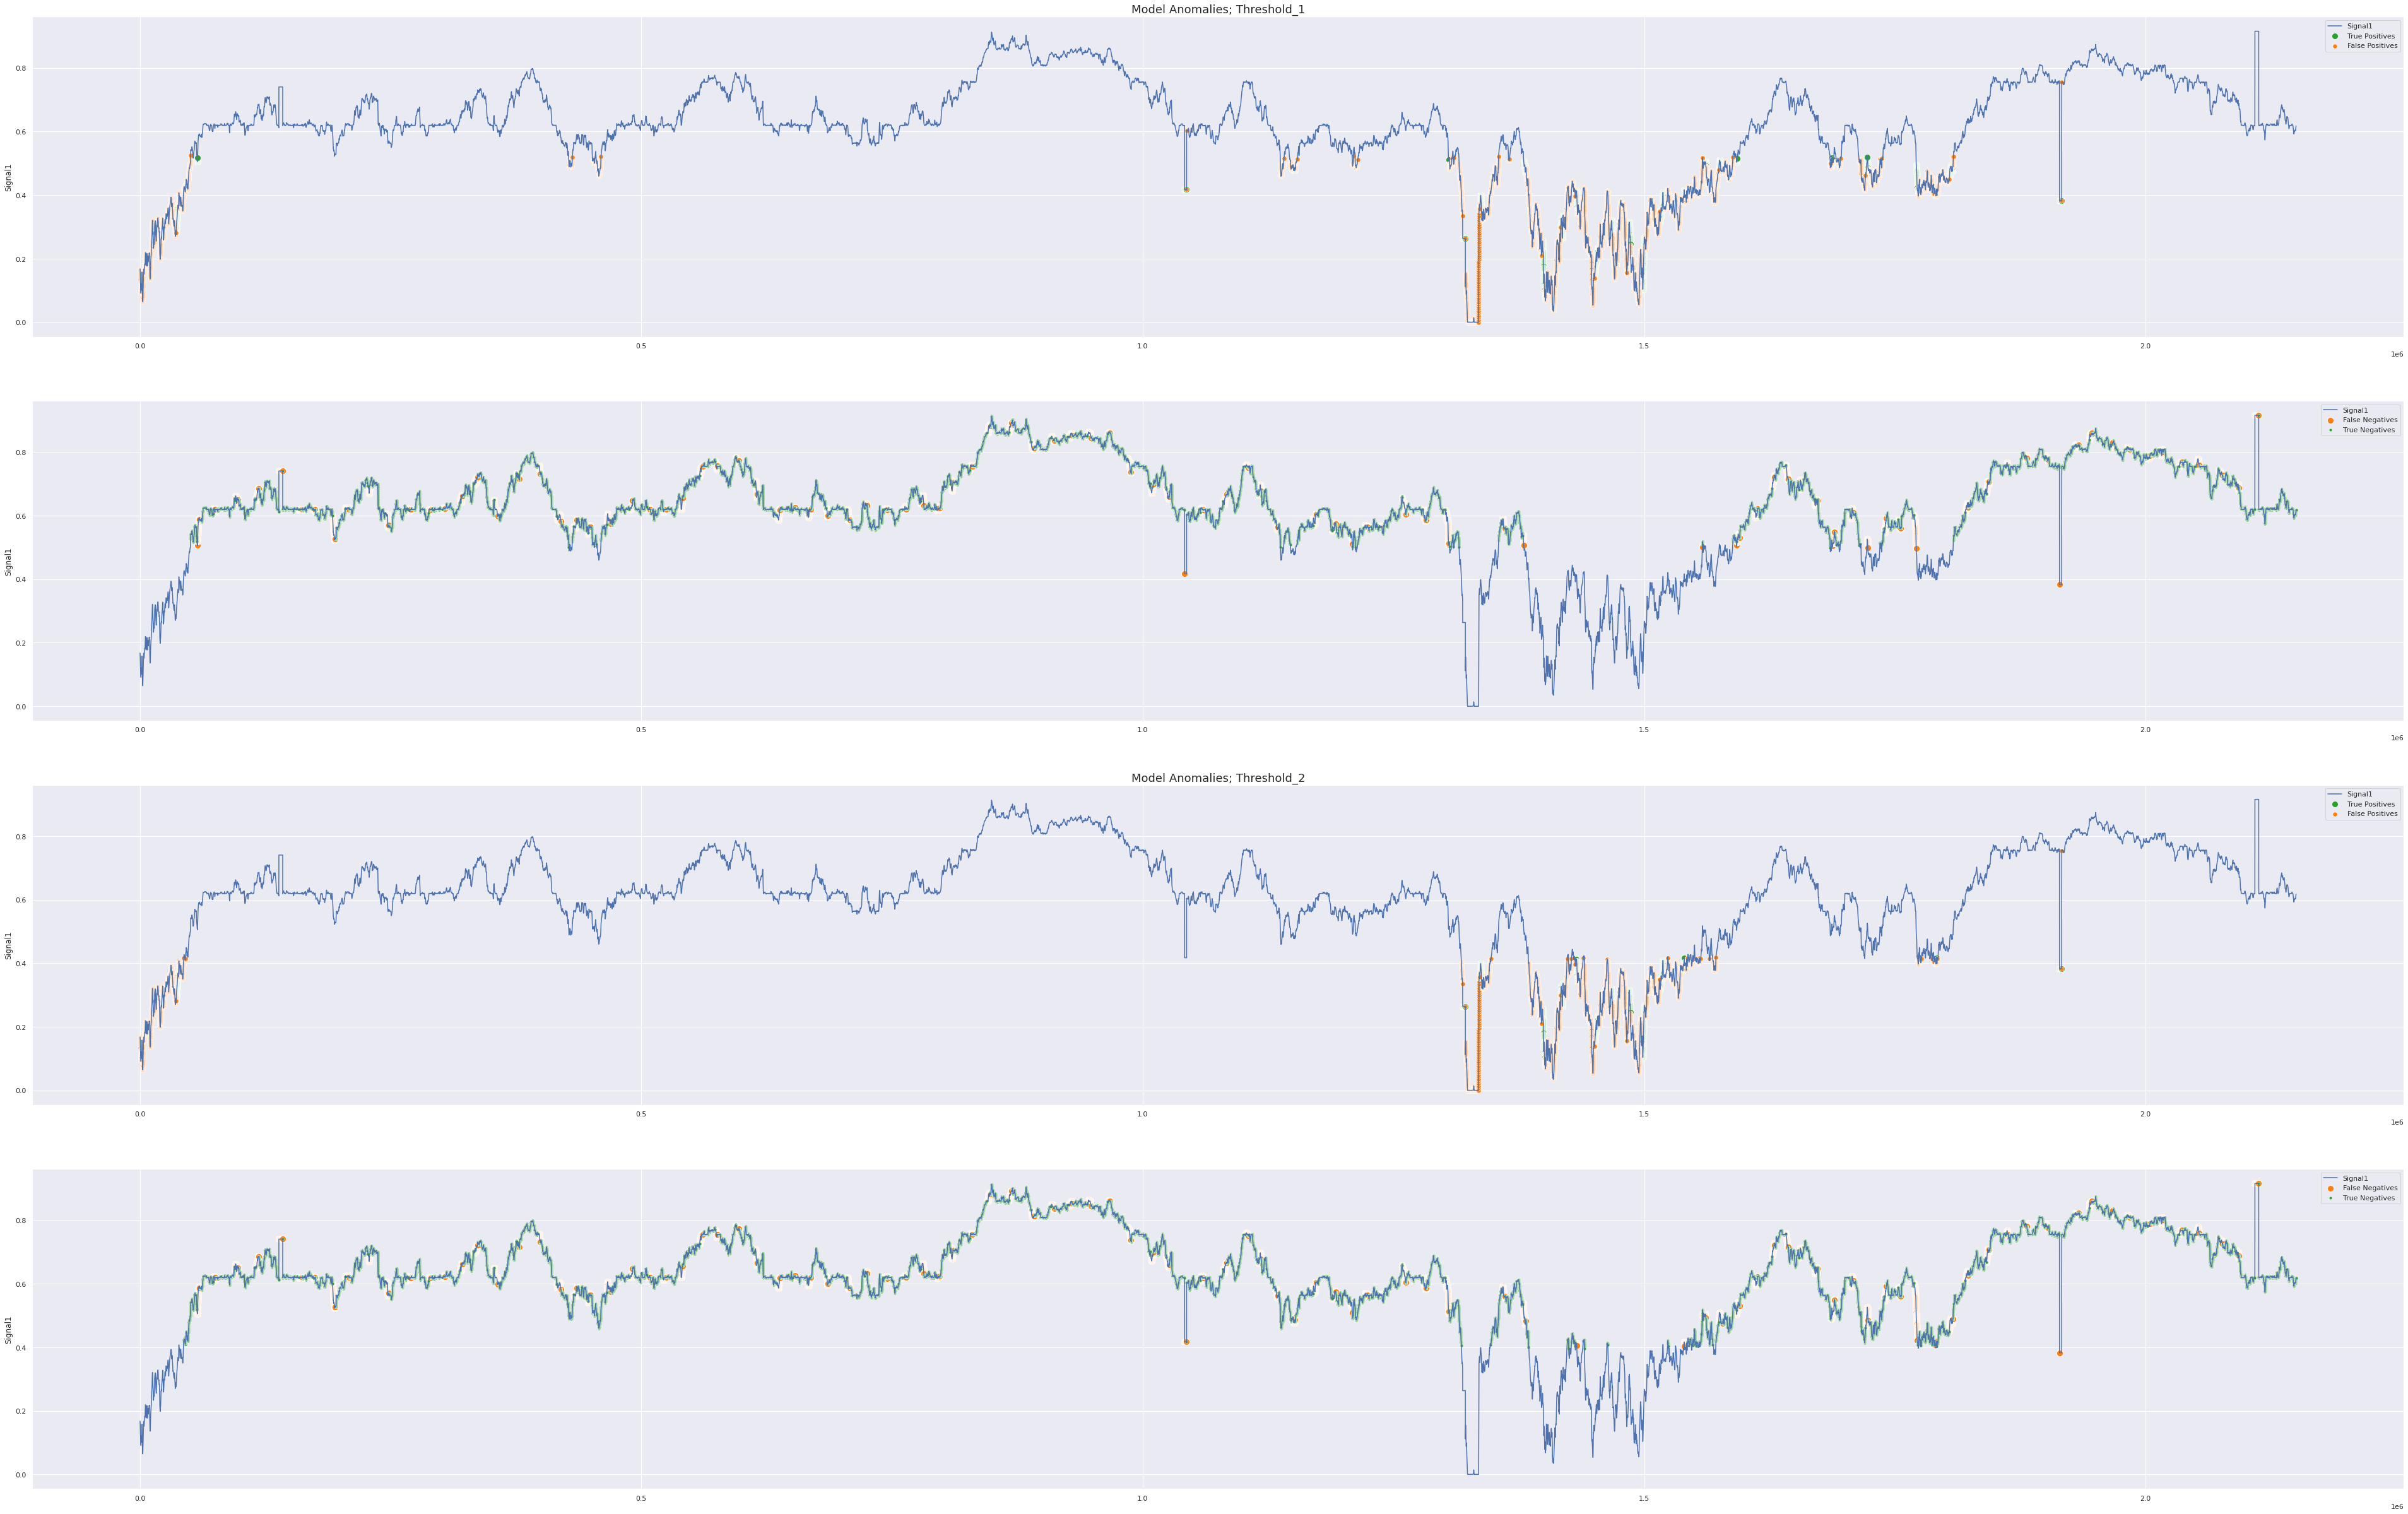

In [41]:
# plt.figure(figsize=(30,10))
fig,axs = plt.subplots(4,1,squeeze=False, figsize=(60,40))

# Threshold 1
axs[0,0].set_title('Model Anomalies; Threshold_1',fontsize=18)

axs[0,0].plot(
test_score_df.index, 
test_score_df.Signal1,
label='Signal1'
)

sns.scatterplot(
  stats_df_1[0].index, 
  stats_df_1[0].Signal1,
  color=sns.color_palette("tab10")[2],
  s=100,
  markers='o',
  label='True Positives',
  ax = axs[0,0]
)

sns.scatterplot(
  stats_df_1[1].index, 
  stats_df_1[1].Signal1,
  color=sns.color_palette("tab10")[1],
  s=52,
  label='False Positives',
  ax = axs[0,0]
)
plt.legend()
axs[1,0].plot(
test_score_df.index, 
test_score_df.Signal1, 
  label='Signal1'
)

sns.scatterplot(
  stats_df_1[2].index, 
  stats_df_1[2].Signal1,
  color=sns.color_palette("tab10")[1],
  s=100,
  markers='o',
  label='False Negatives',
  ax = axs[1,0]
)
sns.scatterplot(
  stats_df_1[3].index, 
  stats_df_1[3].Signal1,
  color=sns.color_palette("tab10")[2],
  s=20,
  markers='o',
  label='True Negatives',
  ax = axs[1,0]
)


# Threshold 2
axs[2,0].set_title('Model Anomalies; Threshold_2',fontsize=18)


axs[2,0].plot(
test_score_df.index, 
test_score_df.Signal1,
label='Signal1'
)

sns.scatterplot(
  stats_df_2[0].index, 
  stats_df_2[0].Signal1,
  color=sns.color_palette("tab10")[2],
  s=100,
  markers='o',
  label='True Positives',
  ax = axs[2,0]
)

sns.scatterplot(
  stats_df_2[1].index, 
  stats_df_2[1].Signal1,
  color=sns.color_palette("tab10")[1],
  s=52,
  label='False Positives',
  ax = axs[2,0]
)
plt.legend()
axs[3,0].plot(
test_score_df.index, 
test_score_df.Signal1, 
  label='Signal1'
)

sns.scatterplot(
  stats_df_2[2].index, 
  stats_df_2[2].Signal1,
  color=sns.color_palette("tab10")[1],
  s=100,
  markers='o',
  label='False Negatives',
  ax = axs[3,0]
)
sns.scatterplot(
  stats_df_2[3].index, 
  stats_df_2[3].Signal1,
  color=sns.color_palette("tab10")[2],
  s=20,
  markers='o',
  label='True Negatives',
  ax = axs[3,0]
)

